# Putting together data from MITCH and MTB Machine

An important step in data pre processing is the marriage of data generated by the two systems.

(Note for data from 8 Jan 21) The systems (mitch and mtb) were not syncronized previously, which should become standard practice to avoid synchronization issues and loss of precision on models

## Importing experiments data (from shoe machine MTB)

Let's start by uploading the files previously created with the "TDMS file importer".

In [1]:
mtb_filename = "Montebelluna_8Jan21_time_series"

import pandas as pd

df_mtb = pd.read_csv(mtb_filename + ".csv", index_col = 0)

# converting time column into correct time format
df_mtb["time"] = pd.to_datetime(df_mtb["time"])
df_mtb.sort_values("time", inplace = True)
df_mtb.reset_index(drop = True, inplace = True)

print("Start time: " + str(df_mtb["time"].min()))
print(df_mtb.info())

Start time: 2021-01-08 10:10:55.052250
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400070 entries, 0 to 400069
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time        400070 non-null  datetime64[ns]
 1   experiment  400070 non-null  object        
 2   session #   400070 non-null  int64         
 3   cycle #     400070 non-null  int64         
 4   position    400070 non-null  float64       
 5   force       400070 non-null  float64       
 6   temp        400070 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(1)
memory usage: 21.4+ MB
None


## Importing data from the MITCH

Let's get data from the experiments.

The code below is taken from "MITCH data loader" from Marilena present in the MTB test related analsys folder in Git.

In [2]:
# For each tdms file below it is required to insert an experiment name to be used as a tag in the consolidated dataframe
file_names = ["08.01.2021 100929", "08.01.2021 104013", "08.01.2021 134757", "08.01.2021 112923"]
experiment_names = ["DxAmbient", "SxAmbient", "DxCold", "SxCold"]

df = pd.DataFrame()

for i, exp in enumerate(experiment_names):
    df_imp = pd.read_csv(file_names[i] + ".txt", delimiter = '\t', skiprows = 8) # delimiter '\t' for blank
    df_imp["experiment"] = exp
    df = df.append(df_imp)

print(df.info())
# print(df.sample(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 55043 entries, 0 to 13109
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Timestamp    55043 non-null  int64  
 1   Acc.X        55043 non-null  float64
 2   Acc.Y        55043 non-null  float64
 3   Acc.Z        55043 non-null  float64
 4   Gyro.X       55043 non-null  float64
 5   Gyro.Y       55043 non-null  float64
 6   Gyro.Z       55043 non-null  float64
 7   Magn.X       55043 non-null  float64
 8   Magn.Y       55043 non-null  float64
 9   Magn.Z       55043 non-null  float64
 10  P.0          55043 non-null  int64  
 11  P.1          55043 non-null  int64  
 12  P.2          55043 non-null  int64  
 13  P.3          55043 non-null  int64  
 14  P.4          55043 non-null  int64  
 15  P.5          55043 non-null  int64  
 16  P.6          55043 non-null  int64  
 17  P.7          55043 non-null  int64  
 18  Temperature  55043 non-null  float64
 19  expe

Now let's transform the timestamp column into a compatible format to the MTB machine data.

In [3]:
# transform timestamp into ms for conversion
df["timestamp"] = df["Timestamp"] / 1000

from datetime import datetime

def getTime(timestamp):
    return datetime.fromtimestamp(timestamp)

df["time"] = df["timestamp"].apply(getTime)

df.drop(["Timestamp", "timestamp"], axis = 1, inplace = True)

df.sort_values("time", inplace = True)
df.reset_index(drop = True, inplace = True)

print(df.info())
# print(df.sample(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55043 entries, 0 to 55042
Data columns (total 20 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Acc.X        55043 non-null  float64       
 1   Acc.Y        55043 non-null  float64       
 2   Acc.Z        55043 non-null  float64       
 3   Gyro.X       55043 non-null  float64       
 4   Gyro.Y       55043 non-null  float64       
 5   Gyro.Z       55043 non-null  float64       
 6   Magn.X       55043 non-null  float64       
 7   Magn.Y       55043 non-null  float64       
 8   Magn.Z       55043 non-null  float64       
 9   P.0          55043 non-null  int64         
 10  P.1          55043 non-null  int64         
 11  P.2          55043 non-null  int64         
 12  P.3          55043 non-null  int64         
 13  P.4          55043 non-null  int64         
 14  P.5          55043 non-null  int64         
 15  P.6          55043 non-null  int64         
 16  P.7 

In [4]:
# some final embelishment of the dataframe
cols = df.columns.to_list()
cols = [cols[-1]] + [cols[-2]] + cols[0:18]
df = df[cols]

new_col_names = ['time', 'experiment', 'Acc.X', 'Acc.Y', 'Acc.Z', 'Gyro.X', 'Gyro.Y', 'Gyro.Z', 'Magn.X', 'Magn.Y', 'Magn.Z', '1A', '1B', '2A', '2B', '3A', '3B', '4A', '4B', 'temp']
df.columns = new_col_names

print(df.columns.to_list())

['time', 'experiment', 'Acc.X', 'Acc.Y', 'Acc.Z', 'Gyro.X', 'Gyro.Y', 'Gyro.Z', 'Magn.X', 'Magn.Y', 'Magn.Z', '1A', '1B', '2A', '2B', '3A', '3B', '4A', '4B', 'temp']


## Visualization and syncronization inspection

Let's plot the data together to see how it looks and if the cycles are well in Sync. 

Let's first do a check to see the difference of time between the start of the measurements for both bases

In [5]:
start_mtb = df_mtb["time"].min()
start_exp = df["time"].min()

print(start_mtb)
print(start_exp)
print(start_exp - start_mtb)

2021-01-08 10:10:55.052250
2021-01-08 11:09:30.477000
0 days 00:58:35.424750


Since it is clear that the MITCH was turned on before the machine, we could expect that there would be only a few seconds of minutes difference. Hence the above value shows a clear gap on 1 hour due to time zone difference. Let's remediate this by substracting one hour MITCH time data.

In [6]:
# removing one hour from MITCH time data
df["new_time"] = df["time"] - pd.Timedelta("1 hour")

print(df[["time", "new_time"]].head(10))

df["time"] = df["new_time"]
df.drop("new_time", axis = 1, inplace = True)


                     time                new_time
0 2021-01-08 11:09:30.477 2021-01-08 10:09:30.477
1 2021-01-08 11:09:30.487 2021-01-08 10:09:30.487
2 2021-01-08 11:09:30.497 2021-01-08 10:09:30.497
3 2021-01-08 11:09:30.507 2021-01-08 10:09:30.507
4 2021-01-08 11:09:30.517 2021-01-08 10:09:30.517
5 2021-01-08 11:09:30.527 2021-01-08 10:09:30.527
6 2021-01-08 11:09:30.537 2021-01-08 10:09:30.537
7 2021-01-08 11:09:30.547 2021-01-08 10:09:30.547
8 2021-01-08 11:09:30.557 2021-01-08 10:09:30.557
9 2021-01-08 11:09:30.567 2021-01-08 10:09:30.567


Now it would be nice to take a look at the data. Let's plot together the data of a cycle

In [7]:
# selecting timeframe to look at
exp = "SxAmbient"
sess = 1
cycle = 3

# Identification of time begining and ending
df_mtb_select = df_mtb[(df_mtb["experiment"] == exp) & (df_mtb["session #"] == sess) & (df_mtb["cycle #"] == cycle)]
times_mtb = df_mtb_select["time"]
start = times_mtb.min()
end = times_mtb.max()
print(end - start)


# get the position variable for the above times
pos = df_mtb_select["position"]

# select the relative data from the mitch
df_select = df[(df["time"] >= start) & (df["time"] <= end)]
times = df_select["time"]
chans_selected = ["1A", "2A", "3A", "4A"]
df_select = df_select[chans_selected]

print(df_select.info())

0 days 00:00:01.427999
<class 'pandas.core.frame.DataFrame'>
Int64Index: 146 entries, 19258 to 19403
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   1A      146 non-null    int64
 1   2A      146 non-null    int64
 2   3A      146 non-null    int64
 3   4A      146 non-null    int64
dtypes: int64(4)
memory usage: 5.7 KB
None


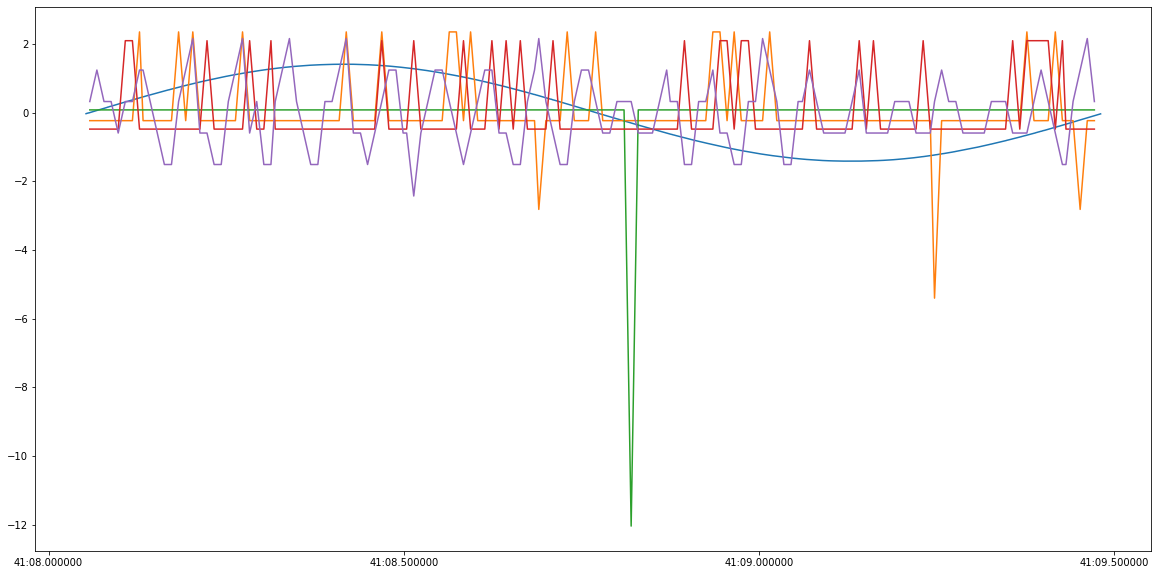

In [8]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# create plot
plt.figure(figsize=(20,10))

# plot mtb data
pos_scaled = pos.values.reshape(-1, 1)
scaler = StandardScaler()
pos_scaled = scaler.fit_transform(pos_scaled)
plt.plot(times_mtb, pos_scaled)

# plot sensors data
for chan in chans_selected:
    scaler = StandardScaler()
    chan_scaled = scaler.fit_transform(df_select[chan].values.reshape(-1,1))
    plt.plot(times, chan_scaled)

plt.show()

(Important] Wow is amess! Some Hypothesis, in order or probability:
- Outliers in the MITCH data
- Simple stupid code errors
- Time lag between data
- Scaling problems

## Interpolation of data

Finally let's add the data from the Montebelluna machine to the MITCH acquisitions. We will strive to get the closest value captured by the machine to the timestamps in the MITCH data.

Given that the machine acquires with roughly 10x more bandwidth than the MITCH, we could simply get the closest timestamp data. This approach however can generate time lapses of up to 20% of error. A better method is to interpolate the data from Montebelluna in the closest previous and later time stamps.

To make the script generic to any dataset in the future we shall take a bold approach. There are significant time differences in terms of availability of data from the mitch and montebelluna machine. One easy way to see it is in the fact that the device was often turned on before the machine started working. This creates a lot of lines of data in the mitch set that won't have corresponding values. Given that the Montebelluna machine acquires at much higher rates than the mitch, we can assume that once the machine is recording, there should be values relatiely close.

We should then establish a threshhold to select correct values. But which one to use? Let's do this iteratively by studying the share of values from the mitch that get corresponding times within a certain allowed threshhold

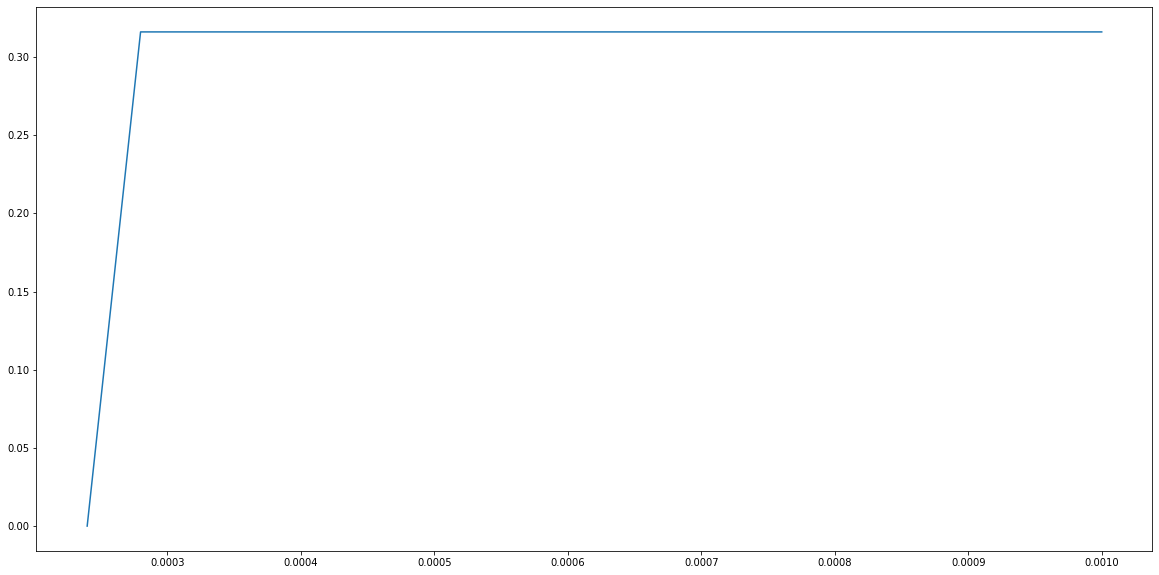

In [21]:
# threshhold delimitation - to be set iteractively
limits = [.00024, .001]

buckets = 20

import numpy as np

thresholds = np.linspace(limits[0], limits[1], num = buckets)

# amount of samples from mith datapoints to include in the study (randomly picked)
sample_size = 500

df_s = df.sample(sample_size)

delta_times = []

for threshold in thresholds:
    
    # variable to get how many mitch values are on target threshold
    on_limits = 0
    
    # iterate through the sample df
    for index, row in df_s.iterrows():
        time = row["time"]

        # get the closest two times in the mtb data
        df_closest = df_mtb.iloc[(df_mtb['time'] - time).abs().argsort()[:2]]

        # calculate times and deltas
        before = df_closest["time"].to_list()[0]
        after = df_closest["time"].to_list()[1]
        delta = (time - before).total_seconds()
        delta = abs(delta)
        
        # check if delta within threshold
        if delta <= threshold:
            on_limits += 1
            
    on_limits_share = on_limits / sample_size
    delta_times.append(on_limits_share)
    
plt.figure(figsize=(20,10))
plt.plot(thresholds, delta_times)
plt.show()
    

From the above graph and previous interactions we can see that a value of .00025s of maximum allowed delta between the mitch and the machine should largely suffice.

This value is also in line with the MTB machine sampling rate. In the dataset we see that two different timestamps for mtb are always separated by .0005s, which would make the closest time possible for mitch when the machine is acquiring of half that value, or .00025. Cool to see the above empirical solution to an analytic problem.

Let's then proceed to the full df interpolation.

In [33]:
# maximum allowed time gap between mitch data and montebelluna data
threshold = .001

# declares a multiple to which a status print should be done
debug_every = 200

# variable to store amounts of mitch data within thershold, for debugging purposes
df_ammended = 0

# declaring new columns in mitch data set
df["experiment"] = ""
df["session #"] = ""
df["cycle #"] = ""
df["position"] = ""
df["force"] = ""
df["temp_mtb"] = ""

# iterating through mitch dataset
for index, row in df.iterrows():
    time = row["time"]

    # get the closest two times in the mtb data
    df_closest = df_mtb.iloc[(df_mtb['time'] - time).abs().argsort()[:2]]
    before = df_closest.iloc[0]
    after = df_closest.iloc[1]

    # calculate times and deltas
    before_time = before["time"]
    after_time = after["time"]
    delta_1 = abs((time - before_time).total_seconds())
    delta_2 = abs((after_time - before_time).total_seconds())
    
    # identify if time from mitch is close enough to a mtb datapoint
    if delta_1 <= threshold and delta_2 > 0:
        
        # interpolate variables
        pos = before["position"] + (delta_1 / delta_2) * (after["position"] - before["position"])
        force = before["force"] + (delta_1 / delta_2) * (after["force"] - before["force"])
        temp = before["temp"] + (delta_1 / delta_2) * (after["temp"] - before["temp"])
        
        # write data on df
        row["experiment"] = after["experiment"]
        row["session #"] = after["session #"]
        row["cycle #"] = after["cycle #"]
        row["position"] = pos
        row["force"] = force
        row["temp_mtb"] = temp
        
        # update counter
        df_ammended += 1
    
    
    # debug
    if index % debug_every == 0:
        print("Iteration: " + str(index + 1) + " out of " + str(df.shape[0]))
        print("Process progress: " + str((index + 1) / df.shape[0]))
        print("Time on MITCH: " + time.strftime("%H:%M:%S.%f"))
        print("Closest before time on mtb: " + before_time.strftime("%H:%M:%S.%f"))
        print("Closest after time on mtb: " + after_time.strftime("%H:%M:%S.%f"))
        print("Delta t - before: " + str(delta_1))
        print("Delta after - before: " + str(delta_2))
        if delta_1 <= threshold: 
            print("Delta 1 within thershold, mitch data ammended")
            print(row)
        else:
            print("Delta 1 without thershold, mitch data not ammended")
        print("Total data points within thershold: " + str(df_ammended))
        print("Share of analyzed rows within thershold :" + str(df_ammended / (index + 1)))
        print()

    

        

Iteration: 1 out of 55043
Process progress: 1.816761441055175e-05
Time on MITCH: 10:09:30.477000
Closest before time on mtb: 10:10:55.052250
Closest after time on mtb: 10:10:55.052750
Delta t - before: 84.57525
Delta after - before: 0.0005
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 0
Share of analyzed rows within thershold :0.0

Iteration: 201 out of 55043
Process progress: 0.003651690496520902
Time on MITCH: 10:09:32.432000
Closest before time on mtb: 10:10:55.052250
Closest after time on mtb: 10:10:55.052750
Delta t - before: 82.62025
Delta after - before: 0.0005
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 0
Share of analyzed rows within thershold :0.0

Iteration: 401 out of 55043
Process progress: 0.007285213378631252
Time on MITCH: 10:09:34.383000
Closest before time on mtb: 10:10:55.052250
Closest after time on mtb: 10:10:55.052750
Delta t - before: 80.66925
Delta after - before: 0.0005
Delta 1 

Iteration: 4401 out of 55043
Process progress: 0.07995567102083825
Time on MITCH: 10:10:13.448000
Closest before time on mtb: 10:10:55.052250
Closest after time on mtb: 10:10:55.052750
Delta t - before: 41.60425
Delta after - before: 0.0005
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 0
Share of analyzed rows within thershold :0.0

Iteration: 4601 out of 55043
Process progress: 0.0835891939029486
Time on MITCH: 10:10:15.399000
Closest before time on mtb: 10:10:55.052250
Closest after time on mtb: 10:10:55.052750
Delta t - before: 39.65325
Delta after - before: 0.0005
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 0
Share of analyzed rows within thershold :0.0

Iteration: 4801 out of 55043
Process progress: 0.08722271678505895
Time on MITCH: 10:10:17.355000
Closest before time on mtb: 10:10:55.052250
Closest after time on mtb: 10:10:55.052750
Delta t - before: 37.69725
Delta after - before: 0.0005
Delta 1 

Iteration: 8801 out of 55043
Process progress: 0.15989317442726594
Time on MITCH: 10:10:56.415000
Closest before time on mtb: 10:10:56.415250
Closest after time on mtb: 10:10:56.414750
Delta t - before: 0.00025
Delta after - before: 0.0005
Delta 1 within thershold, mitch data ammended
time          2021-01-08 10:10:56.415000
experiment                     DxAmbient
Acc.X                              0.488
Acc.Y                            1028.22
Acc.Z                            338.672
Gyro.X                            -22.47
Gyro.Y                              0.42
Gyro.Z                               4.9
Magn.X                              1620
Magn.Y                               630
Magn.Z                             -1140
1A                                   253
1B                                   135
2A                                   253
2B                                   253
3A                                   173
3B                                   137
4A               

Iteration: 12001 out of 55043
Process progress: 0.21802954054103155
Time on MITCH: 10:11:27.667000
Closest before time on mtb: 10:11:27.645750
Closest after time on mtb: 10:11:27.645250
Delta t - before: 0.02125
Delta after - before: 0.0005
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 293
Share of analyzed rows within thershold :0.0244146321139905

Iteration: 12201 out of 55043
Process progress: 0.2216630634231419
Time on MITCH: 10:11:29.618000
Closest before time on mtb: 10:11:27.645750
Closest after time on mtb: 10:11:27.645250
Delta t - before: 1.97225
Delta after - before: 0.0005
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 293
Share of analyzed rows within thershold :0.024014425047127284

Iteration: 12401 out of 55043
Process progress: 0.22529658630525226
Time on MITCH: 10:11:31.574000
Closest before time on mtb: 10:11:34.500250
Closest after time on mtb: 10:11:34.500750
Delta t - before: 2.92625
D

Iteration: 15801 out of 55043
Process progress: 0.2870664753011282
Time on MITCH: 10:40:34.288000
Closest before time on mtb: 10:41:05.195251
Closest after time on mtb: 10:41:05.195752
Delta t - before: 30.907251
Delta after - before: 0.000501
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 440
Share of analyzed rows within thershold :0.027846338839313967

Iteration: 16001 out of 55043
Process progress: 0.29069999818323855
Time on MITCH: 10:40:36.239000
Closest before time on mtb: 10:41:05.195251
Closest after time on mtb: 10:41:05.195752
Delta t - before: 28.956251
Delta after - before: 0.000501
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 440
Share of analyzed rows within thershold :0.027498281357415163

Iteration: 16201 out of 55043
Process progress: 0.29433352106534894
Time on MITCH: 10:40:38.195000
Closest before time on mtb: 10:41:05.195251
Closest after time on mtb: 10:41:05.195752
Delta t - before:

Iteration: 19401 out of 55043
Process progress: 0.3524698871791145
Time on MITCH: 10:41:09.442000
Closest before time on mtb: 10:41:09.441751
Closest after time on mtb: 10:41:09.442252
Delta t - before: 0.000249
Delta after - before: 0.000501
Delta 1 within thershold, mitch data ammended
time          2021-01-08 10:41:09.442000
experiment                     SxAmbient
Acc.X                            -98.576
Acc.Y                             956.48
Acc.Z                            255.712
Gyro.X                             -0.14
Gyro.Y                                 0
Gyro.Z                                 0
Magn.X                            -682.5
Magn.Y                           -1411.5
Magn.Z                            -172.5
1A                                   211
1B                                   136
2A                                   253
2B                                   253
3A                                   140
3B                                   143
4A            

Iteration: 21001 out of 55043
Process progress: 0.3815380702359973
Time on MITCH: 10:41:25.068000
Closest before time on mtb: 10:41:25.067751
Closest after time on mtb: 10:41:25.068252
Delta t - before: 0.000249
Delta after - before: 0.000501
Delta 1 within thershold, mitch data ammended
time          2021-01-08 10:41:25.068000
experiment                     SxAmbient
Acc.X                           -120.536
Acc.Y                            936.472
Acc.Z                             336.72
Gyro.X                              0.14
Gyro.Y                             -0.07
Gyro.Z                             -0.07
Magn.X                            -667.5
Magn.Y                           -1426.5
Magn.Z                              -210
1A                                   209
1B                                   136
2A                                   253
2B                                   253
3A                                   137
3B                                   137
4A            

Iteration: 22201 out of 55043
Process progress: 0.4033392075286594
Time on MITCH: 10:41:36.787000
Closest before time on mtb: 10:41:36.786752
Closest after time on mtb: 10:41:36.787251
Delta t - before: 0.000248
Delta after - before: 0.000499
Delta 1 within thershold, mitch data ammended
time          2021-01-08 10:41:36.787000
experiment                     SxAmbient
Acc.X                           -106.384
Acc.Y                            946.232
Acc.Z                            326.472
Gyro.X                             -8.26
Gyro.Y                             -0.49
Gyro.Z                             -0.98
Magn.X                              -660
Magn.Y                           -1417.5
Magn.Z                            -220.5
1A                                   208
1B                                   135
2A                                   253
2B                                   253
3A                                   135
3B                                   134
4A            

Iteration: 24001 out of 55043
Process progress: 0.43604091346765256
Time on MITCH: 10:41:54.364000
Closest before time on mtb: 10:41:54.363752
Closest after time on mtb: 10:41:54.364252
Delta t - before: 0.000248
Delta after - before: 0.0005
Delta 1 within thershold, mitch data ammended
time          2021-01-08 10:41:54.364000
experiment                     SxAmbient
Acc.X                            -77.104
Acc.Y                            974.048
Acc.Z                            186.904
Gyro.X                              3.36
Gyro.Y                              0.49
Gyro.Z                              0.42
Magn.X                              -693
Magn.Y                             -1413
Magn.Z                              -162
1A                                   212
1B                                   134
2A                                   253
2B                                   253
3A                                   141
3B                                   146
4A             

Iteration: 25801 out of 55043
Process progress: 0.4687426194066457
Time on MITCH: 10:42:11.946000
Closest before time on mtb: 10:42:11.945752
Closest after time on mtb: 10:42:11.946252
Delta t - before: 0.000248
Delta after - before: 0.0005
Delta 1 within thershold, mitch data ammended
time          2021-01-08 10:42:11.946000
experiment                     SxAmbient
Acc.X                            -102.48
Acc.Y                            960.384
Acc.Z                            216.184
Gyro.X                             -0.21
Gyro.Y                              0.14
Gyro.Z                             -0.07
Magn.X                              -693
Magn.Y                           -1417.5
Magn.Z                              -168
1A                                   211
1B                                   135
2A                                   253
2B                                   253
3A                                   142
3B                                   146
4A              

Iteration: 27601 out of 55043
Process progress: 0.5014443253456389
Time on MITCH: 10:42:29.523000
Closest before time on mtb: 10:42:29.522752
Closest after time on mtb: 10:42:29.523252
Delta t - before: 0.000248
Delta after - before: 0.0005
Delta 1 within thershold, mitch data ammended
time          2021-01-08 10:42:29.523000
experiment                     SxAmbient
Acc.X                            -95.648
Acc.Y                            964.776
Acc.Z                             209.84
Gyro.X                             -0.07
Gyro.Y                              0.07
Gyro.Z                                 0
Magn.X                            -697.5
Magn.Y                           -1417.5
Magn.Z                            -166.5
1A                                   212
1B                                   135
2A                                   253
2B                                   253
3A                                   142
3B                                   146
4A              

Iteration: 29201 out of 55043
Process progress: 0.5305125084025216
Time on MITCH: 11:29:30.329000
Closest before time on mtb: 11:30:13.416254
Closest after time on mtb: 11:30:13.416755
Delta t - before: 43.087254
Delta after - before: 0.000501
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 7025
Share of analyzed rows within thershold :0.24057395294681688

Iteration: 29401 out of 55043
Process progress: 0.534146031284632
Time on MITCH: 11:29:32.280000
Closest before time on mtb: 11:30:13.416254
Closest after time on mtb: 11:30:13.416755
Delta t - before: 41.136254
Delta after - before: 0.000501
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 7025
Share of analyzed rows within thershold :0.2389374511071052

Iteration: 29601 out of 55043
Process progress: 0.5377795541667424
Time on MITCH: 11:29:34.236000
Closest before time on mtb: 11:30:13.416254
Closest after time on mtb: 11:30:13.416755
Delta t - before: 39.

Iteration: 33401 out of 55043
Process progress: 0.606816488926839
Time on MITCH: 11:30:11.345000
Closest before time on mtb: 11:30:13.416254
Closest after time on mtb: 11:30:13.416755
Delta t - before: 2.071254
Delta after - before: 0.000501
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 7025
Share of analyzed rows within thershold :0.21032304422023293

Iteration: 33601 out of 55043
Process progress: 0.6104500118089494
Time on MITCH: 11:30:13.296000
Closest before time on mtb: 11:30:13.416254
Closest after time on mtb: 11:30:13.416755
Delta t - before: 0.120254
Delta after - before: 0.000501
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 7025
Share of analyzed rows within thershold :0.20907115859647035

Iteration: 33801 out of 55043
Process progress: 0.6140835346910597
Time on MITCH: 11:30:15.252000
Closest before time on mtb: 11:30:15.251755
Closest after time on mtb: 11:30:15.252254
Delta t - before: 0.00

Iteration: 35001 out of 55043
Process progress: 0.6358846719837218
Time on MITCH: 11:30:26.967000
Closest before time on mtb: 11:30:26.274755
Closest after time on mtb: 11:30:26.274255
Delta t - before: 0.692245
Delta after - before: 0.0005
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 8342
Share of analyzed rows within thershold :0.2383360475414988

Iteration: 35201 out of 55043
Process progress: 0.6395181948658322
Time on MITCH: 11:30:28.922000
Closest before time on mtb: 11:30:26.274755
Closest after time on mtb: 11:30:26.274255
Delta t - before: 2.647245
Delta after - before: 0.0005
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 8342
Share of analyzed rows within thershold :0.236981903923184

Iteration: 35401 out of 55043
Process progress: 0.6431517177479426
Time on MITCH: 11:30:30.873000
Closest before time on mtb: 11:30:33.152255
Closest after time on mtb: 11:30:33.152755
Delta t - before: 2.279255
D

Iteration: 36801 out of 55043
Process progress: 0.6685863779227149
Time on MITCH: 11:30:44.548000
Closest before time on mtb: 11:30:44.547755
Closest after time on mtb: 11:30:44.548254
Delta t - before: 0.000245
Delta after - before: 0.000499
Delta 1 within thershold, mitch data ammended
time          2021-01-08 11:30:44.548000
experiment                        SxCold
Acc.X                            -83.448
Acc.Y                            961.848
Acc.Z                            111.752
Gyro.X                            -22.33
Gyro.Y                             -5.67
Gyro.Z                             -0.56
Magn.X                            -697.5
Magn.Y                           -1414.5
Magn.Z                              -144
1A                                   200
1B                                   125
2A                                   253
2B                                   162
3A                                   134
3B                                   141
4A            

Iteration: 38601 out of 55043
Process progress: 0.7012880838617082
Time on MITCH: 11:31:02.125000
Closest before time on mtb: 11:31:02.124755
Closest after time on mtb: 11:31:02.125255
Delta t - before: 0.000245
Delta after - before: 0.0005
Delta 1 within thershold, mitch data ammended
time          2021-01-08 11:31:02.125000
experiment                        SxCold
Acc.X                           -105.408
Acc.Y                            958.432
Acc.Z                            234.728
Gyro.X                             -0.14
Gyro.Y                              0.28
Gyro.Z                                 0
Magn.X                            -685.5
Magn.Y                             -1416
Magn.Z                              -174
1A                                   202
1B                                   127
2A                                   253
2B                                   253
3A                                   132
3B                                   136
4A              

Iteration: 40401 out of 55043
Process progress: 0.7339897898007013
Time on MITCH: 11:31:19.702000
Closest before time on mtb: 11:31:19.701755
Closest after time on mtb: 11:31:19.702255
Delta t - before: 0.000245
Delta after - before: 0.0005
Delta 1 within thershold, mitch data ammended
time          2021-01-08 11:31:19.702000
experiment                        SxCold
Acc.X                           -104.432
Acc.Y                            967.704
Acc.Z                            216.184
Gyro.X                             -0.21
Gyro.Y                              0.21
Gyro.Z                              0.07
Magn.X                            -685.5
Magn.Y                           -1408.5
Magn.Z                              -168
1A                                   201
1B                                   127
2A                                   253
2B                                   162
3A                                   133
3B                                   137
4A              

Iteration: 42601 out of 55043
Process progress: 0.7739585415039151
Time on MITCH: 13:48:07.531000
Closest before time on mtb: 13:49:16.321246
Closest after time on mtb: 13:49:16.321745
Delta t - before: 68.790246
Delta after - before: 0.000499
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 12292
Share of analyzed rows within thershold :0.2885378277505223

Iteration: 42801 out of 55043
Process progress: 0.7775920643860255
Time on MITCH: 13:48:09.487000
Closest before time on mtb: 13:49:16.321246
Closest after time on mtb: 13:49:16.321745
Delta t - before: 66.834246
Delta after - before: 0.000499
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 12292
Share of analyzed rows within thershold :0.2871895516459896

Iteration: 43001 out of 55043
Process progress: 0.7812255872681358
Time on MITCH: 13:48:11.438000
Closest before time on mtb: 13:49:16.321246
Closest after time on mtb: 13:49:16.321745
Delta t - before: 6

Iteration: 46801 out of 55043
Process progress: 0.8502625220282325
Time on MITCH: 13:48:48.547000
Closest before time on mtb: 13:49:16.321246
Closest after time on mtb: 13:49:16.321745
Delta t - before: 27.774246
Delta after - before: 0.000499
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 12292
Share of analyzed rows within thershold :0.2626439605991325

Iteration: 47001 out of 55043
Process progress: 0.8538960449103429
Time on MITCH: 13:48:50.502000
Closest before time on mtb: 13:49:16.321246
Closest after time on mtb: 13:49:16.321745
Delta t - before: 25.819246
Delta after - before: 0.000499
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 12292
Share of analyzed rows within thershold :0.2615263505031808

Iteration: 47201 out of 55043
Process progress: 0.8575295677924532
Time on MITCH: 13:48:52.453000
Closest before time on mtb: 13:49:16.321246
Closest after time on mtb: 13:49:16.321745
Delta t - before: 2

Iteration: 50201 out of 55043
Process progress: 0.9120324110241084
Time on MITCH: 13:49:21.750000
Closest before time on mtb: 13:49:21.750246
Closest after time on mtb: 13:49:21.749745
Delta t - before: 0.000246
Delta after - before: 0.000501
Delta 1 within thershold, mitch data ammended
time          2021-01-08 13:49:21.750000
experiment                        DxCold
Acc.X                              90.28
Acc.Y                            983.808
Acc.Z                            196.176
Gyro.X                            -21.63
Gyro.Y                              1.33
Gyro.Z                              1.05
Magn.X                            1600.5
Magn.Y                             643.5
Magn.Z                           -1123.5
1A                                   253
1B                                   122
2A                                   253
2B                                   253
3A                                   159
3B                                   125
4A            

Iteration: 52001 out of 55043
Process progress: 0.9447341169631016
Time on MITCH: 13:49:39.331000
Closest before time on mtb: 13:49:39.331245
Closest after time on mtb: 13:49:39.330745
Delta t - before: 0.000245
Delta after - before: 0.0005
Delta 1 within thershold, mitch data ammended
time          2021-01-08 13:49:39.331000
experiment                        DxCold
Acc.X                             85.888
Acc.Y                            985.272
Acc.Z                            290.848
Gyro.X                             -0.42
Gyro.Y                             -0.28
Gyro.Z                              0.35
Magn.X                            1603.5
Magn.Y                               624
Magn.Z                             -1149
1A                                   253
1B                                   122
2A                                   253
2B                                   253
3A                                   153
3B                                   123
4A              

Iteration: 53601 out of 55043
Process progress: 0.9738023000199844
Time on MITCH: 13:49:54.953000
Closest before time on mtb: 13:49:55.772245
Closest after time on mtb: 13:49:55.772746
Delta t - before: 0.819245
Delta after - before: 0.000501
Delta 1 without thershold, mitch data not ammended
Total data points within thershold: 14925
Share of analyzed rows within thershold :0.27844629764370066

Iteration: 53801 out of 55043
Process progress: 0.9774358229020947
Time on MITCH: 13:49:56.908000
Closest before time on mtb: 13:49:56.908246
Closest after time on mtb: 13:49:56.907745
Delta t - before: 0.000246
Delta after - before: 0.000501
Delta 1 within thershold, mitch data ammended
time          2021-01-08 13:49:56.908000
experiment                        DxCold
Acc.X                             74.176
Acc.Y                            987.712
Acc.Z                            264.984
Gyro.X                             -0.35
Gyro.Y                             -0.28
Gyro.Z                    

Iteration: 55001 out of 55043
Process progress: 0.9992369601947568
Time on MITCH: 13:50:08.628000
Closest before time on mtb: 13:50:08.628245
Closest after time on mtb: 13:50:08.627745
Delta t - before: 0.000245
Delta after - before: 0.0005
Delta 1 within thershold, mitch data ammended
time          2021-01-08 13:50:08.628000
experiment                        DxCold
Acc.X                             81.496
Acc.Y                            986.736
Acc.Z                            267.424
Gyro.X                             -0.28
Gyro.Y                             -0.14
Gyro.Z                              0.35
Magn.X                              1608
Magn.Y                               633
Magn.Z                             -1149
1A                                   253
1B                                   124
2A                                   253
2B                                   253
3A                                   155
3B                                   124
4A              

In [34]:
df.to_csv("MitchAndMTB_8Jan21_time_series-th0010.csv")